In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=7
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'AUSS.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [4]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,other_investing_cf_items,cash_from_investing,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,shares
0,2006-03-31,333,0,333,0,0,-314,-1,19,-4,...,36,36,-51,0,0,0,-51,0,10,203
1,2006-06-30,422,0,422,0,0,-384,7,46,-6,...,-875,-875,1627,0,0,0,1627,0,753,203
2,2006-09-30,1090,0,1090,0,0,-1034,-33,23,-3,...,-124,-124,-600,0,0,0,-600,0,-173,203
3,2006-12-31,887,0,887,0,0,-776,-5,106,-31,...,-34,-34,379,0,0,0,379,-9,695,203
4,2007-03-31,848,0,848,0,0,-765,7,90,-39,...,-1098,-1098,1512,0,0,0,1512,0,10,203


## Calculate date when quaterly reports could be available

In [5]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [6]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
67,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,11847,48062,2380,1153,1778,7879,5968,19899,561,-463
68,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,12177,50267,2164,1640,1734,8146,6061,20460,450,-471
69,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,12301,51933,2617,1249,1414,7556,9051,24871,926,-440
70,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,12265,52401,2950,2466,1290,8635,8939,26029,1086,-478
71,2023-12-31,2024-02-11,203,8754,-4883,3871,767,5475,3106,11865,...,12265,52825,2671,1462,1255,8601,8850,25784,740,-578


## Pull historical average USD national currency rates and add to the dataframe

In [7]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
67,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,48062,2380,1153,1778,7879,5968,19899,561,-463,10.186402
68,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,20460,450,-471,10.221379
69,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,24871,926,-440,10.699984
70,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,26029,1086,-478,10.483742
71,2023-12-31,2024-02-11,203,8754,-4883,3871,767,5475,3106,11865,...,52825,2671,1462,1255,8601,8850,25784,740,-578,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [8]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
67,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,48062,2380,1153,1778,7879,5968,19899,561,-463,10.186402
68,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,20460,450,-471,10.221379
69,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,24871,926,-440,10.699984
70,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,26029,1086,-478,10.483742
71,2023-12-31,2024-02-11,203,8754,-4883,3871,767,5475,3106,11865,...,52825,2671,1462,1255,8601,8850,25784,740,-578,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [9]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [10]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [11]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [12]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2006-10-09,21.396420,2006-06-30,422,0.788177,14.738916,203,4,0.019704,889,...,0.426150,0.573850,2.588957,0.0,1.898763,0.0,1.0,0.094787,0.022789,0.053476
1,2006-10-16,21.287254,2006-06-30,422,0.788177,14.738916,203,4,0.019704,889,...,0.426150,0.573850,2.588957,0.0,1.898763,0.0,1.0,0.094787,0.022789,0.053476
2,2006-10-23,21.014338,2006-09-30,1090,0.394089,14.384236,203,2204,10.857143,716,...,0.472415,0.527585,7.744227,0.0,6.089385,0.0,1.0,0.018349,0.012943,0.027397
3,2006-10-30,20.741428,2006-09-30,1090,0.394089,14.384236,203,2204,10.857143,716,...,0.472415,0.527585,7.744227,0.0,6.089385,0.0,1.0,0.018349,0.012943,0.027397
4,2006-11-06,20.195599,2006-09-30,1090,0.394089,14.384236,203,2204,10.857143,716,...,0.472415,0.527585,7.744227,0.0,6.089385,0.0,1.0,0.018349,0.012943,0.027397


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [13]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2006-10-09,21.396420,2006-06-30,422,0.788177,14.738916,203,4,0.019704,889,...,0.0,1.0,0.094787,0.022789,0.053476,27.146707,1.451696,2.573148,4.433337,1085.868291
1,2006-10-16,21.287254,2006-06-30,422,0.788177,14.738916,203,4,0.019704,889,...,0.0,1.0,0.094787,0.022789,0.053476,27.008204,1.444289,2.560019,4.420209,1080.328157
2,2006-10-23,21.014338,2006-09-30,1090,0.394089,14.384236,203,2204,10.857143,716,...,0.0,1.0,0.018349,0.012943,0.027397,53.323882,1.460928,0.978420,1.562135,1.935531
3,2006-10-30,20.741428,2006-09-30,1090,0.394089,14.384236,203,2204,10.857143,716,...,0.0,1.0,0.018349,0.012943,0.027397,52.631375,1.441955,0.965713,1.549429,1.910395
4,2006-11-06,20.195599,2006-09-30,1090,0.394089,14.384236,203,2204,10.857143,716,...,0.0,1.0,0.018349,0.012943,0.027397,51.246331,1.404009,0.940300,1.524015,1.860121


# Calculate Dividend yield and currency-share price correlation

In [14]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

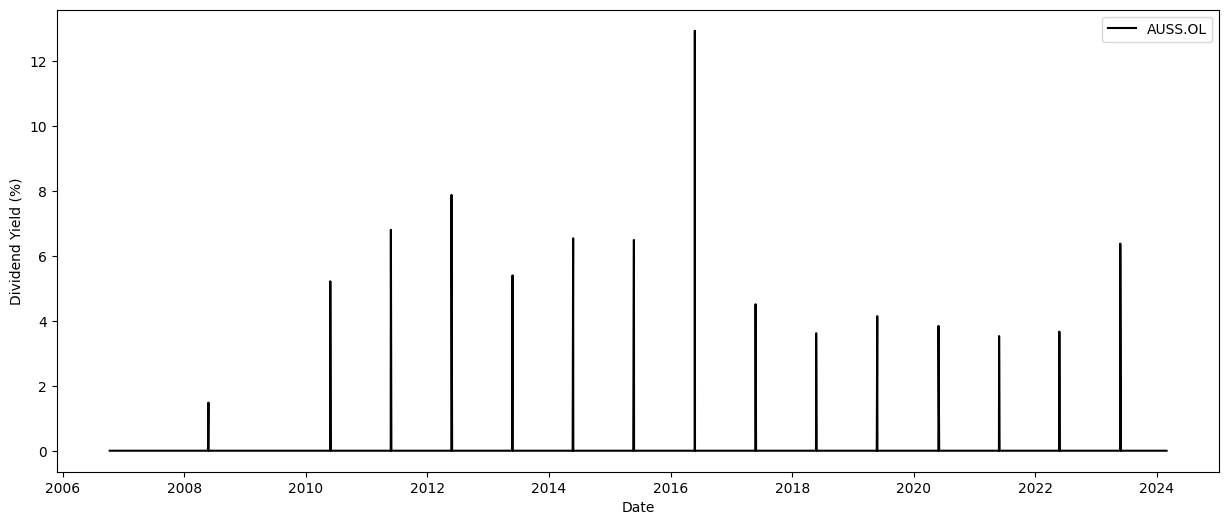

In [15]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.820097
share_price      1.000000
Name: share_price, dtype: float64


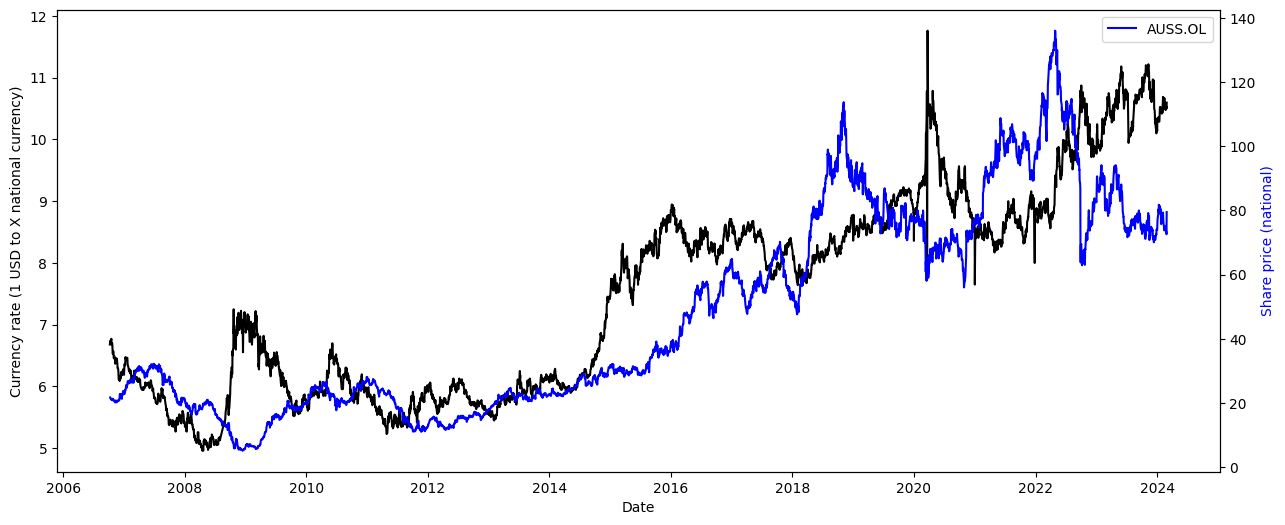

In [16]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

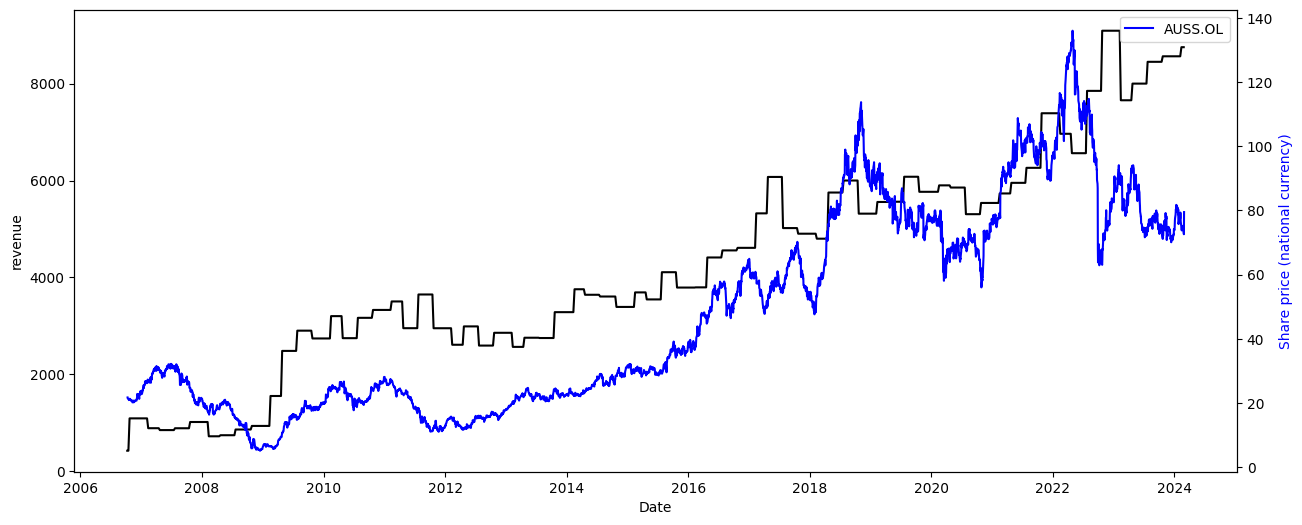

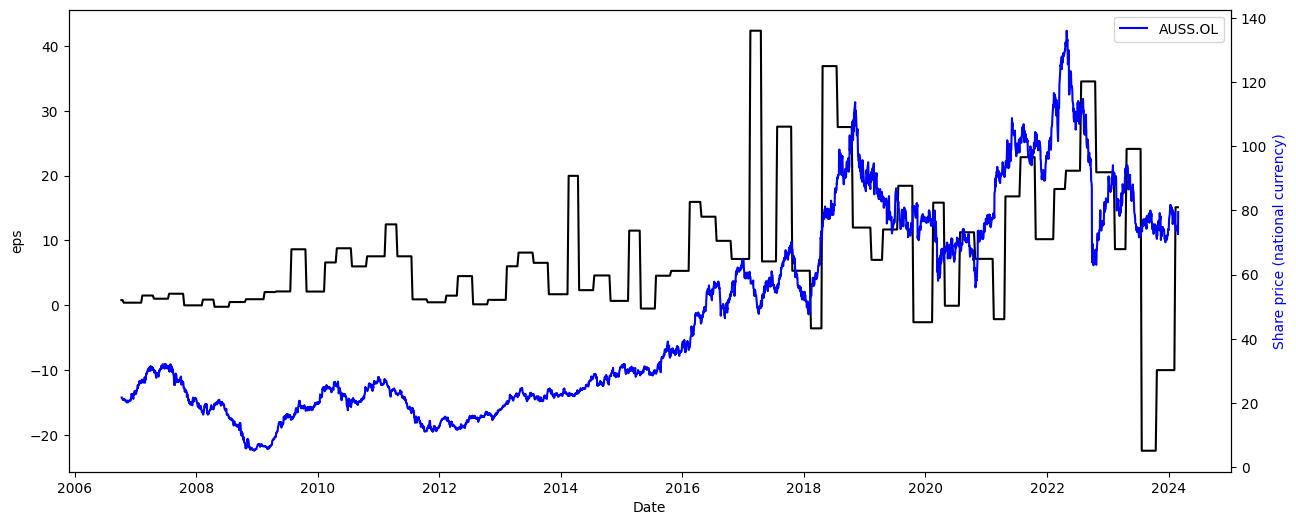

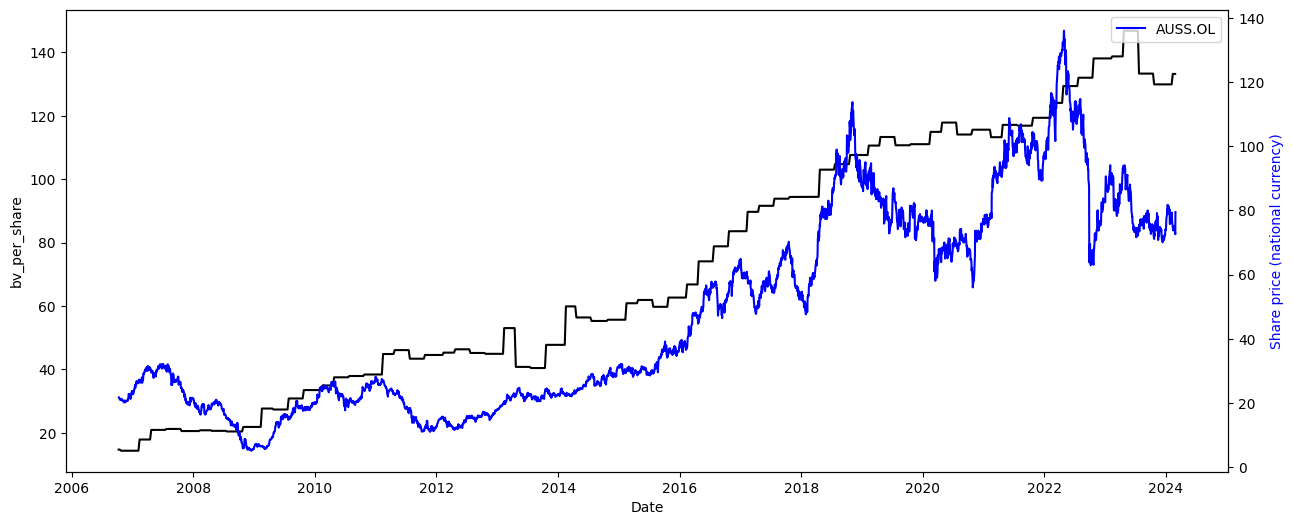

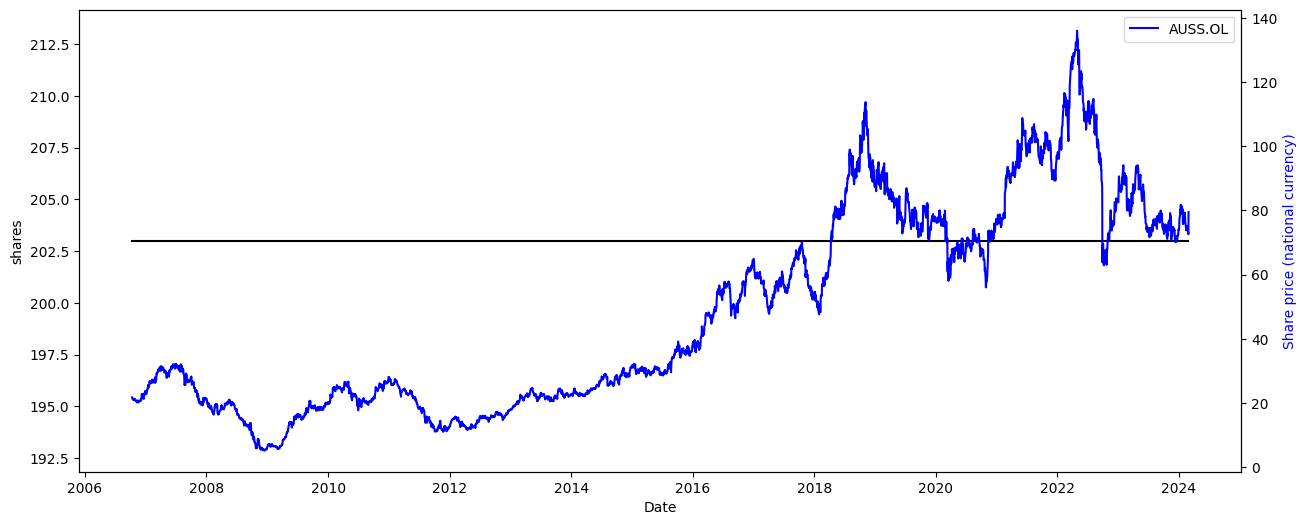

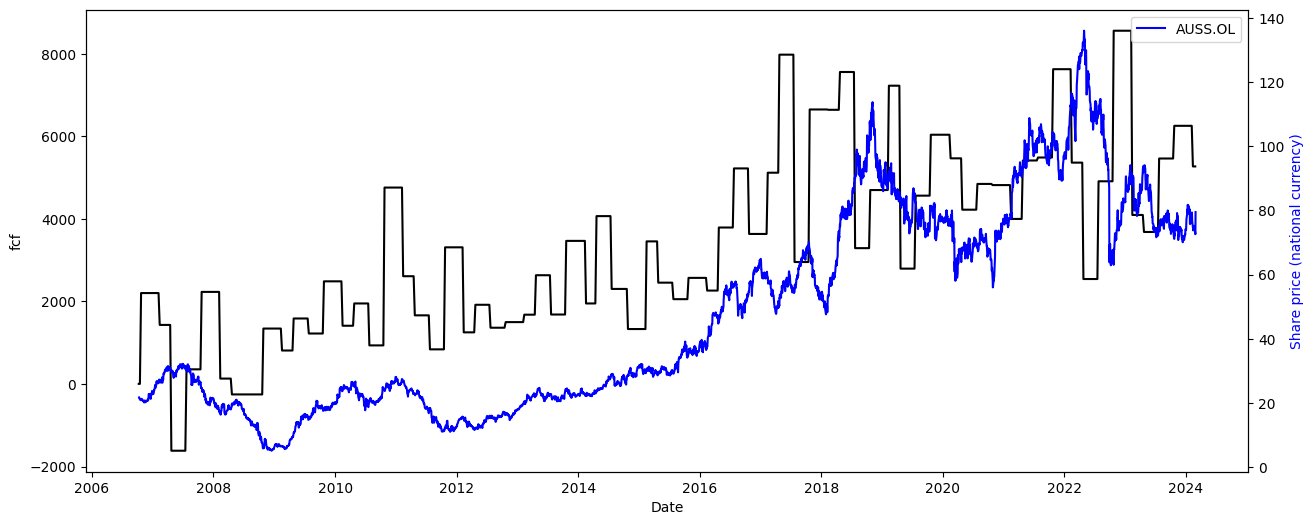

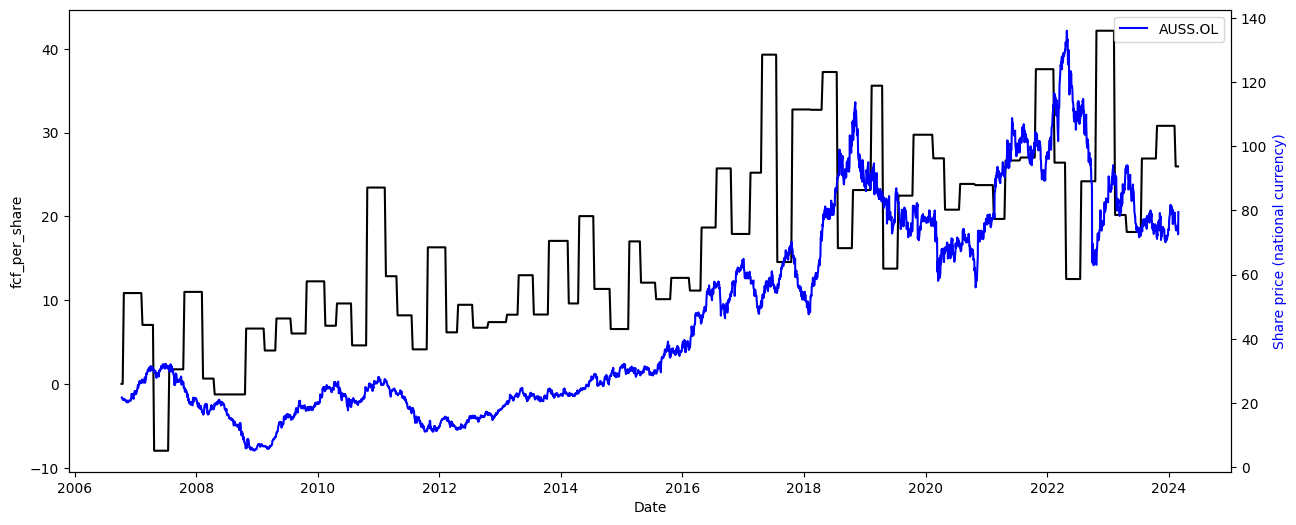

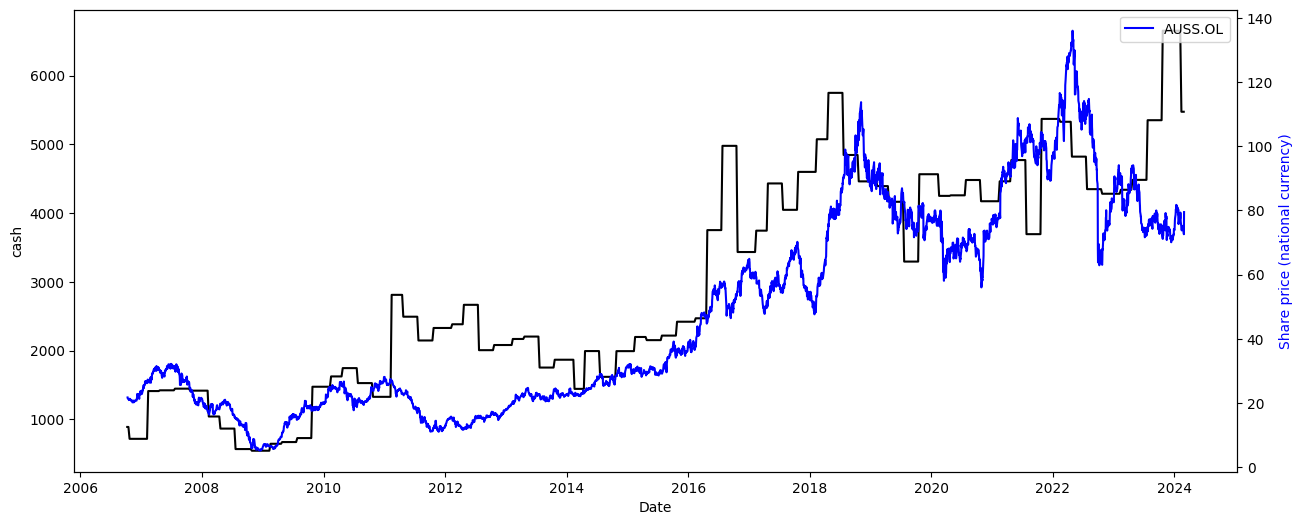

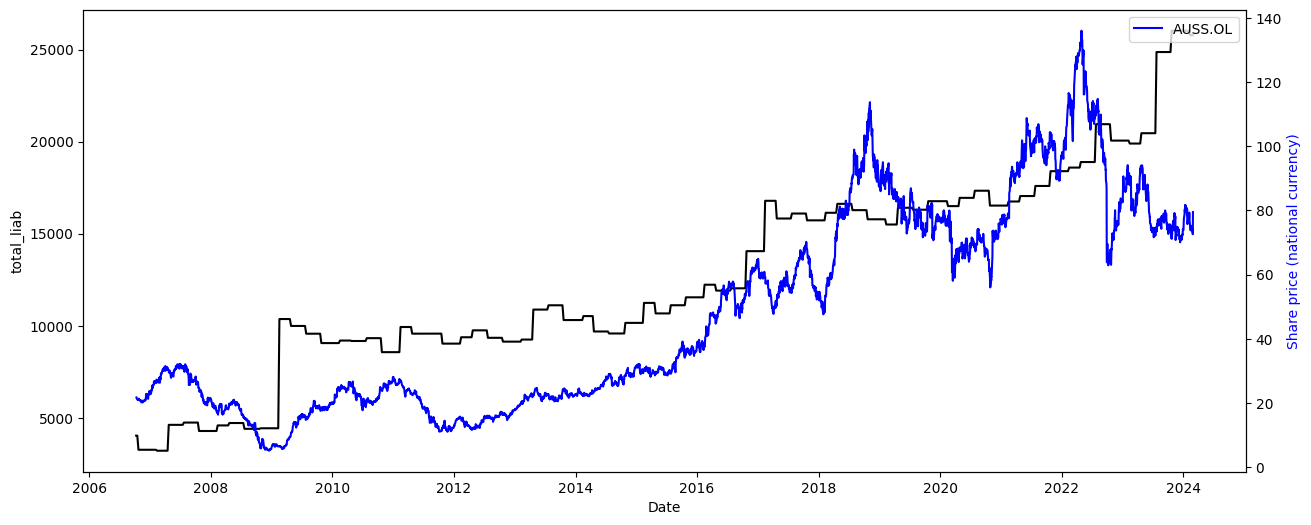

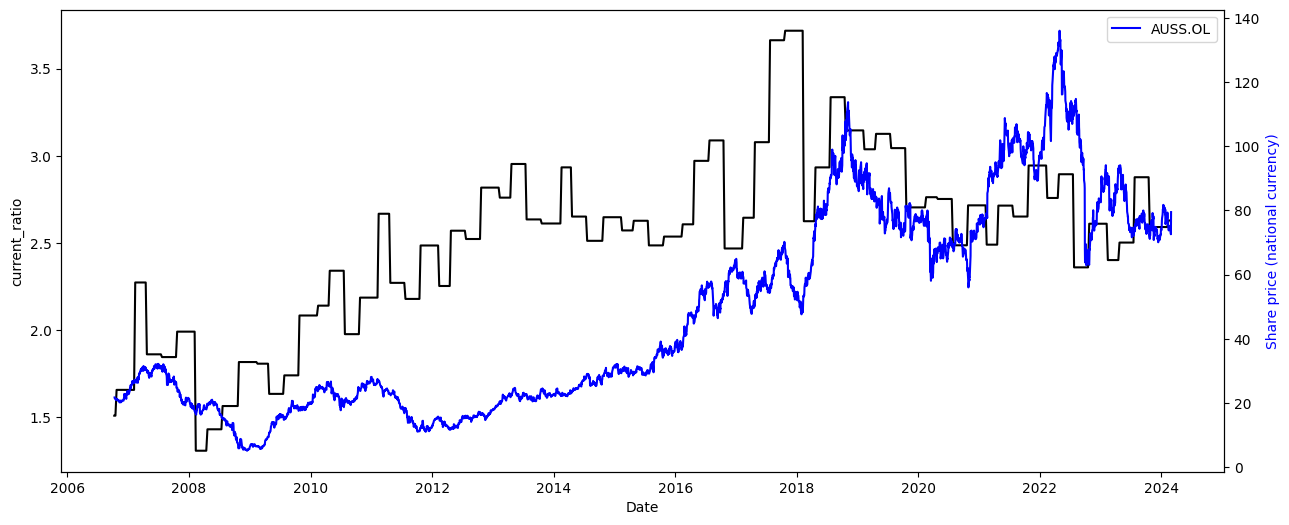

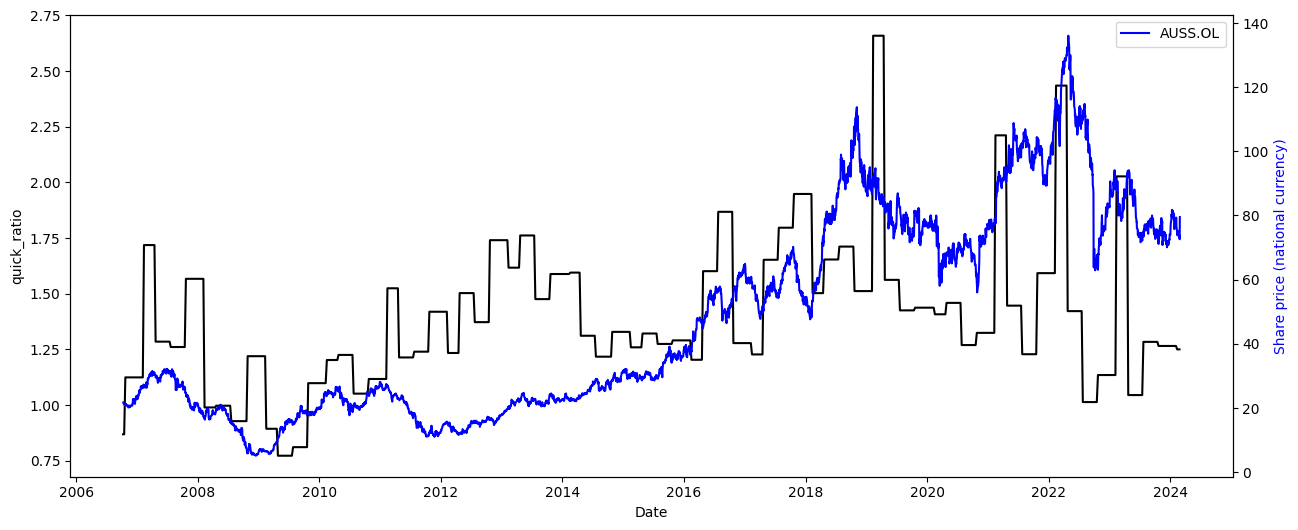

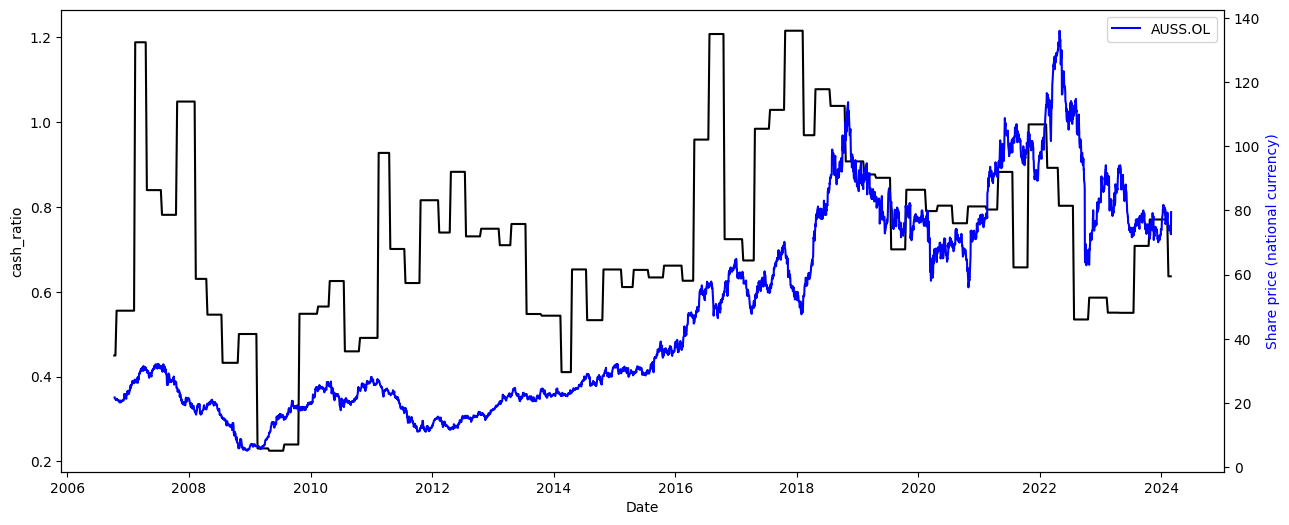

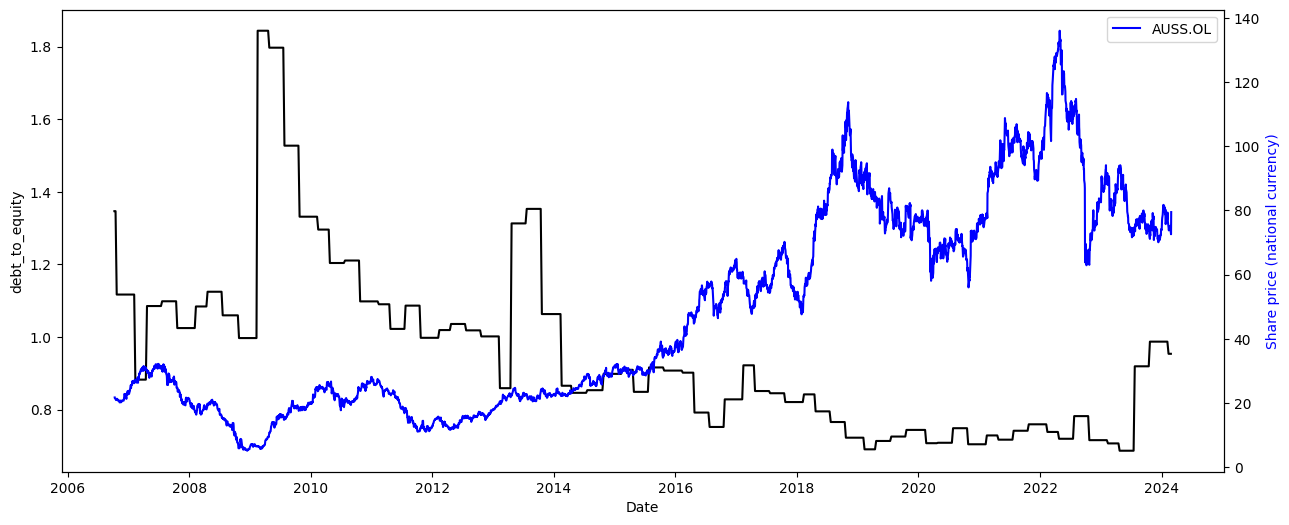

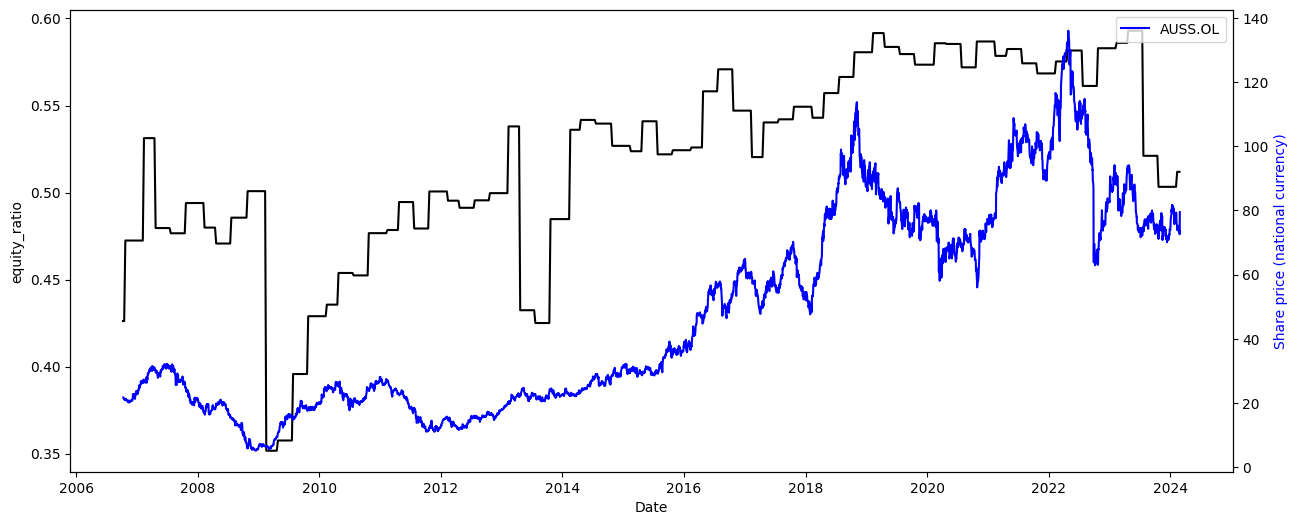

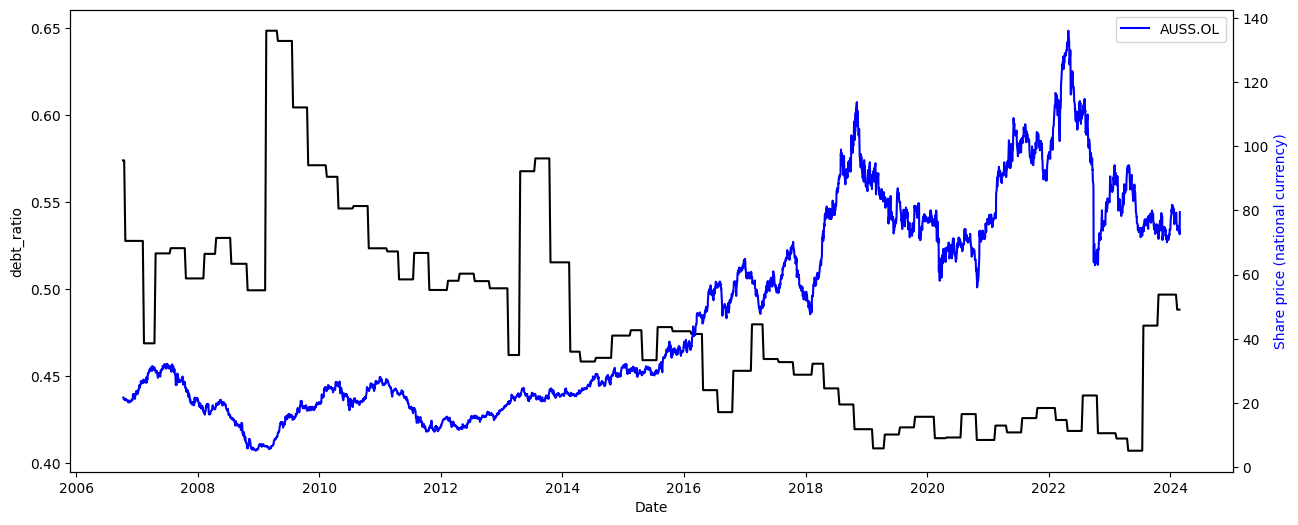

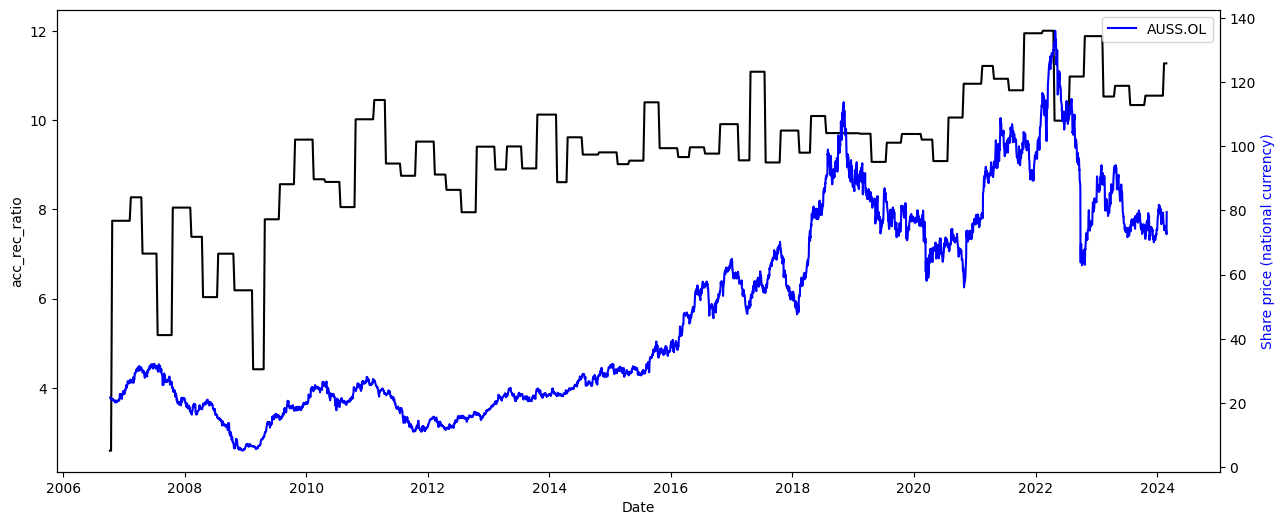

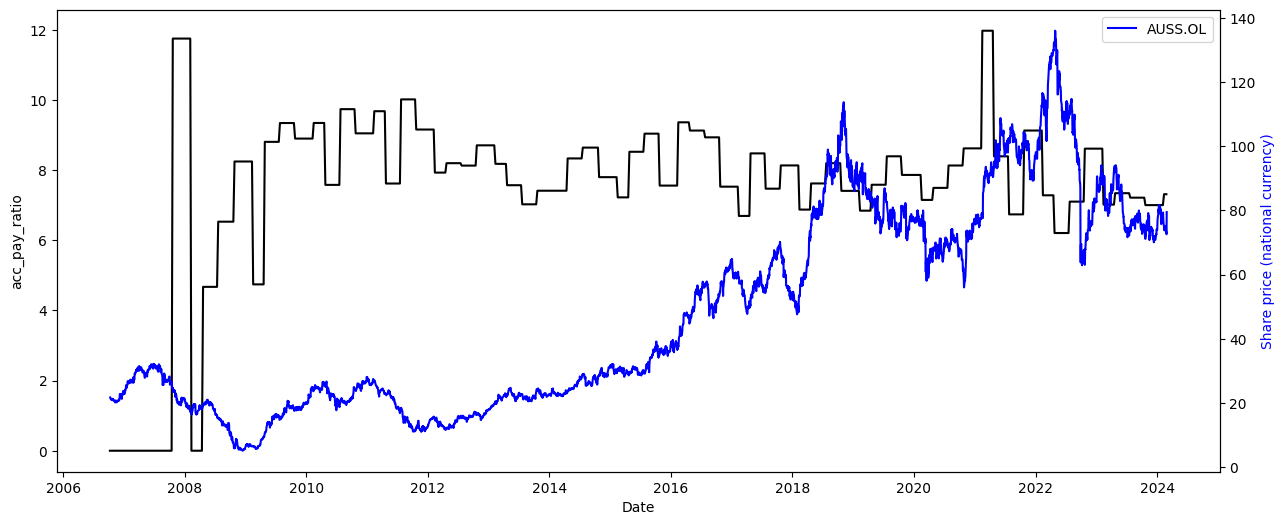

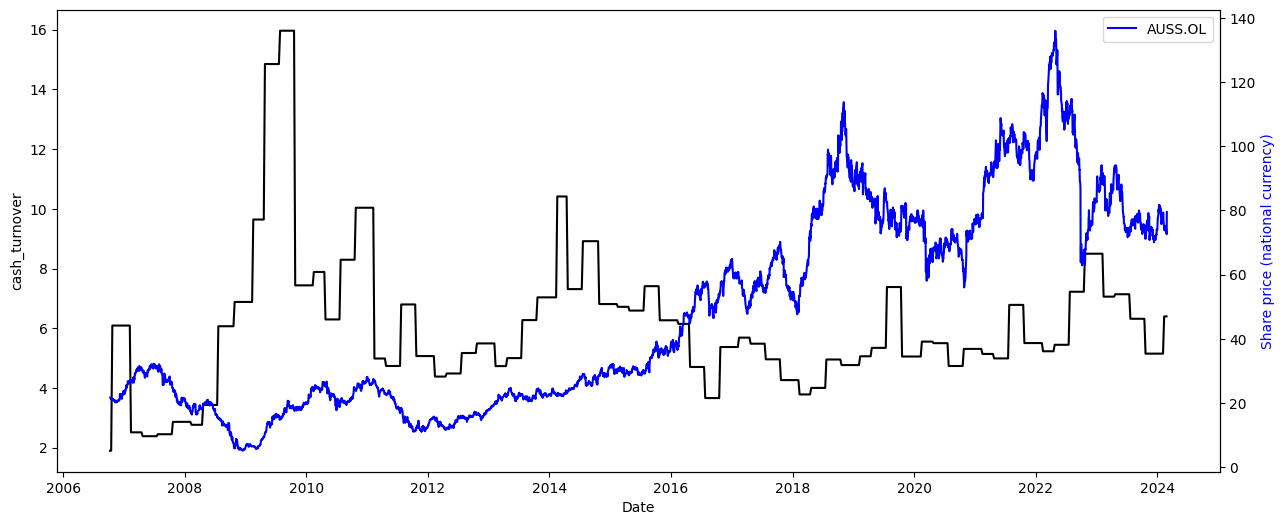

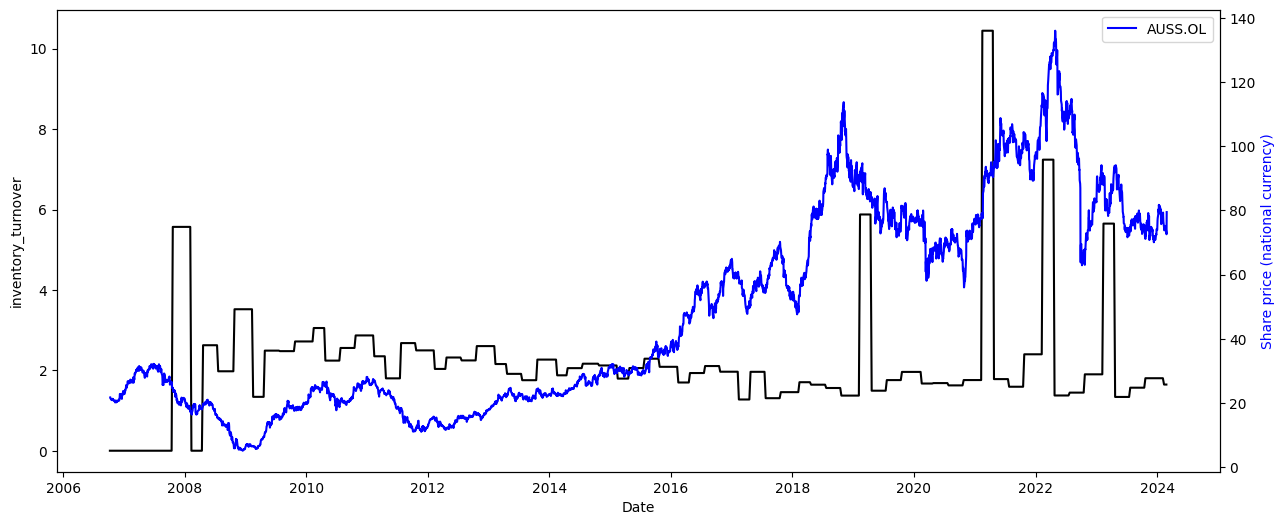

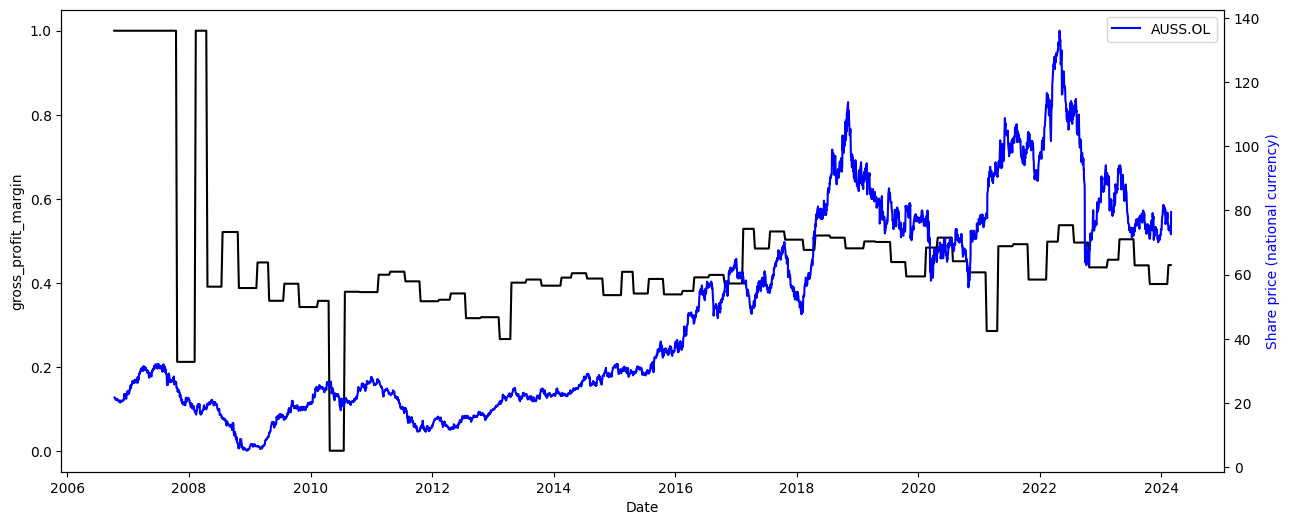

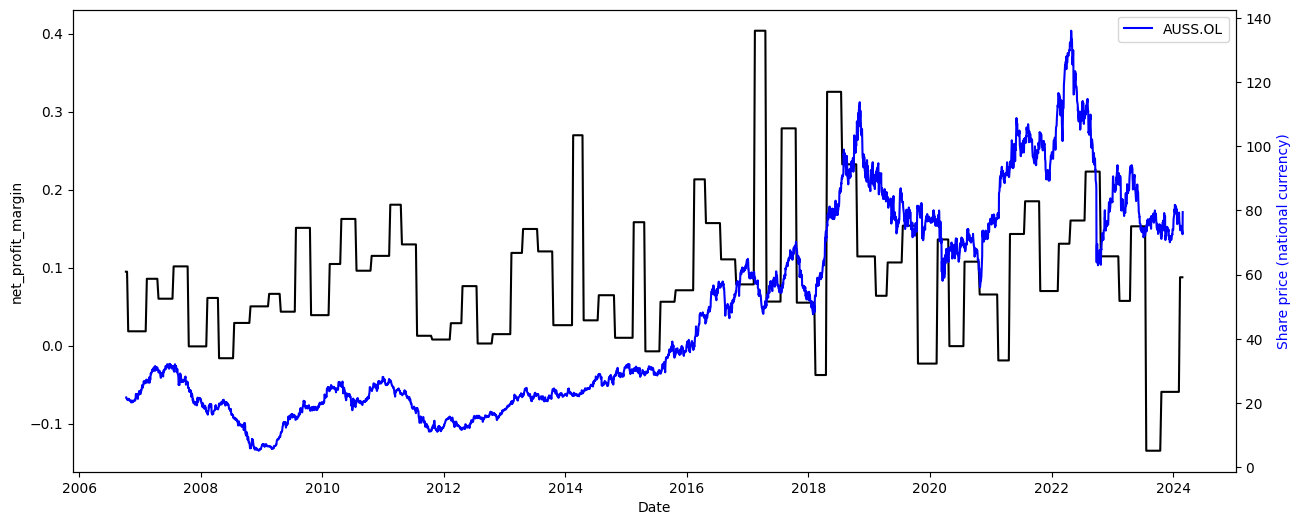

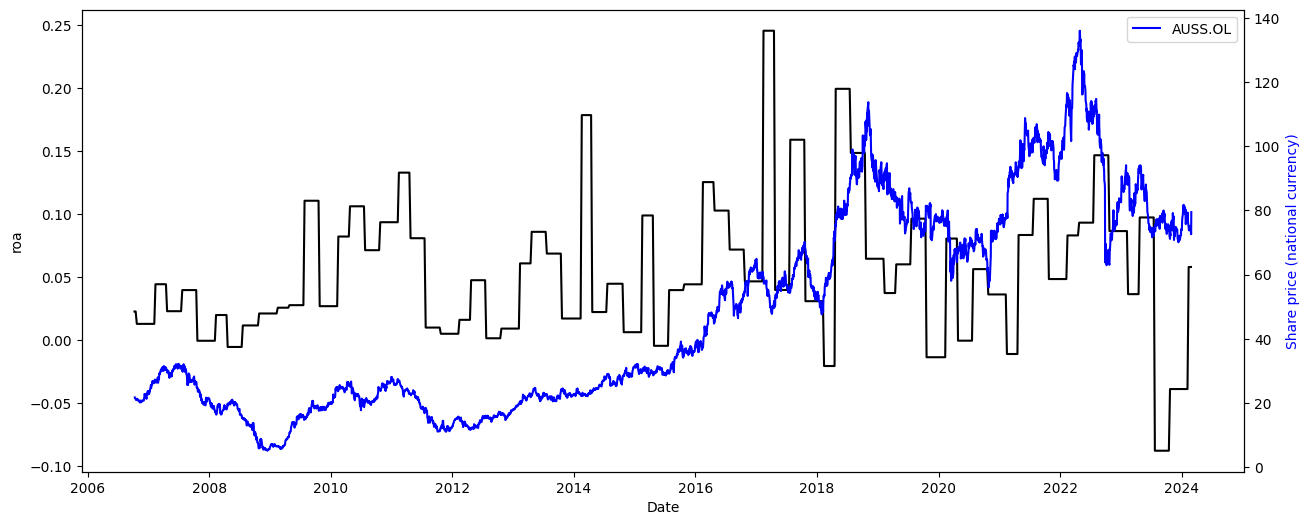

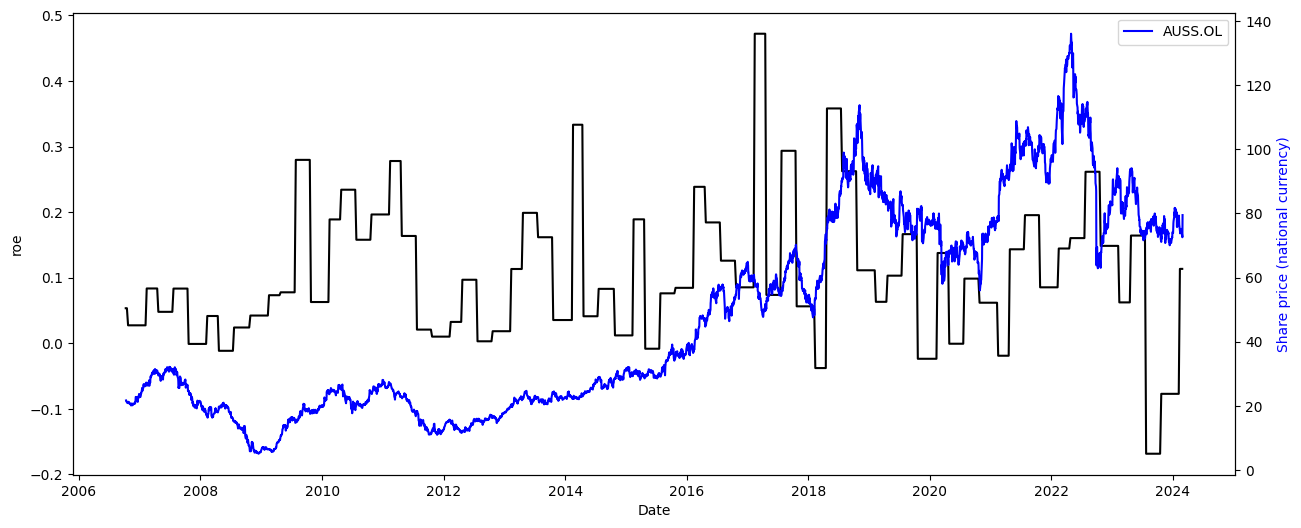

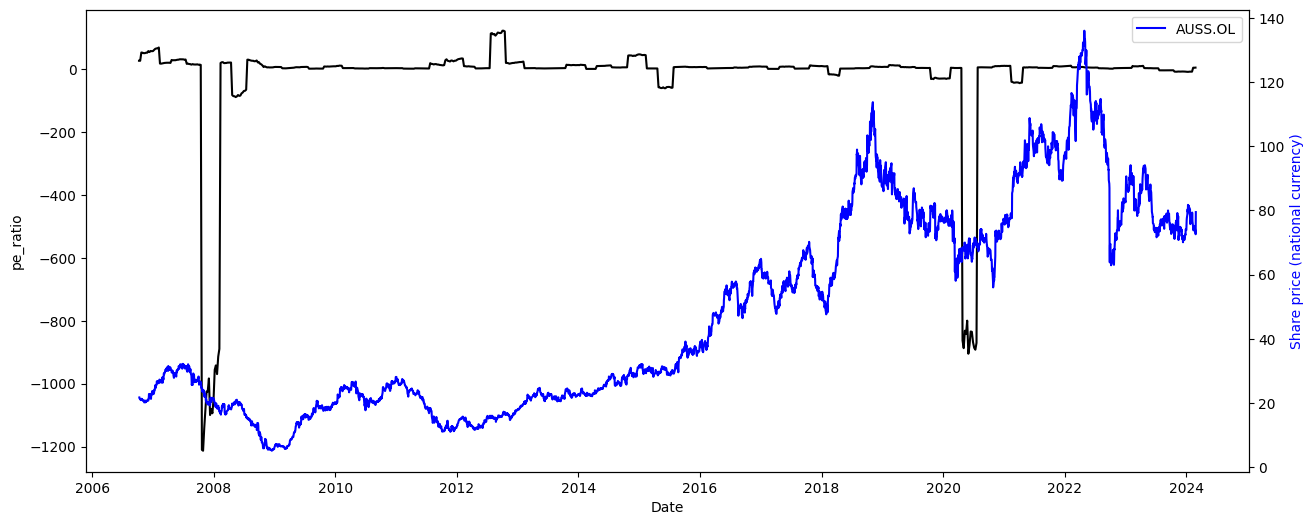

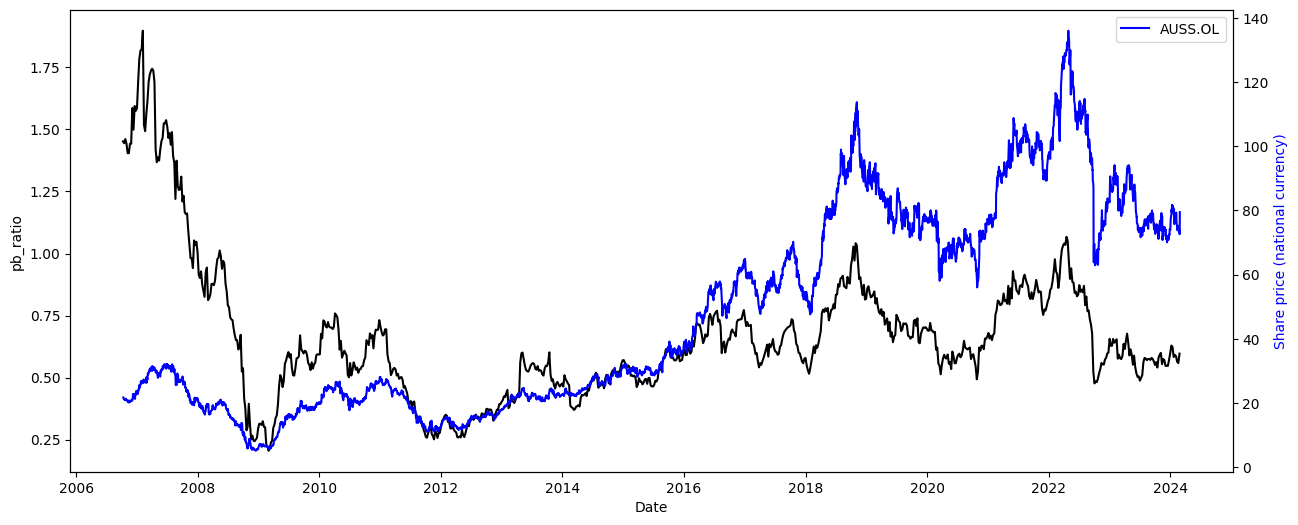

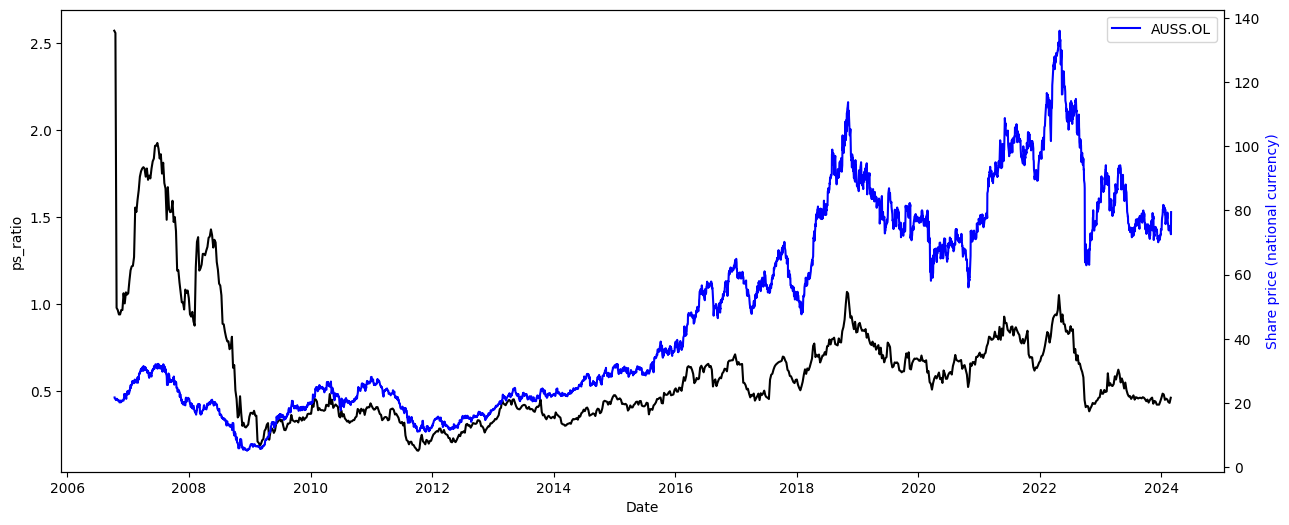

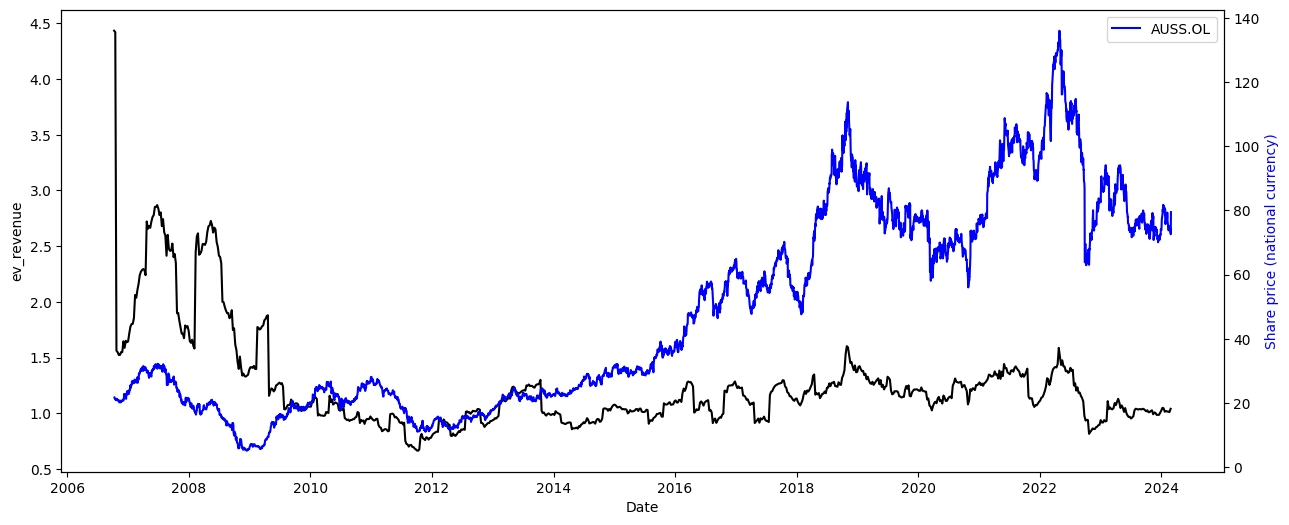

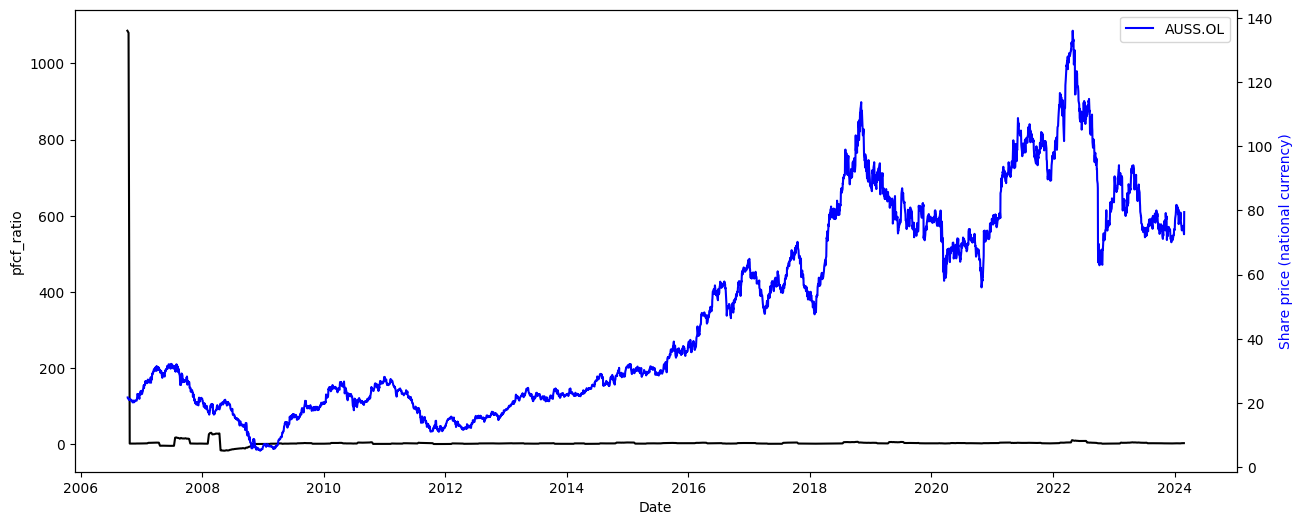

In [17]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

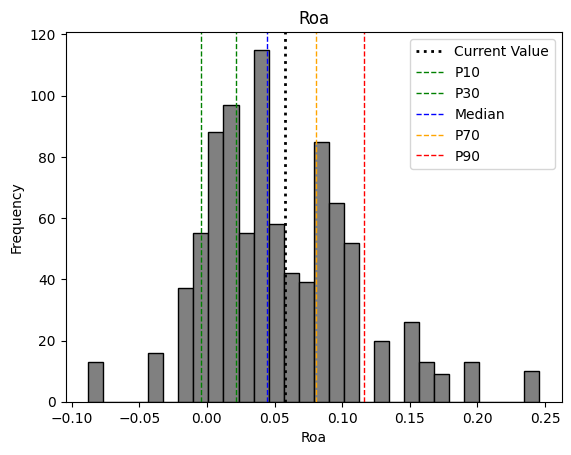

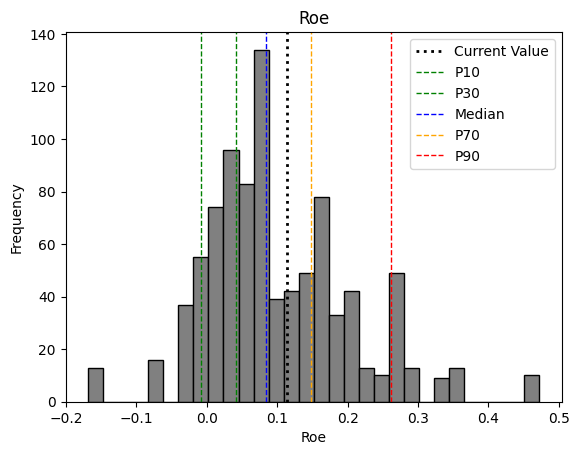

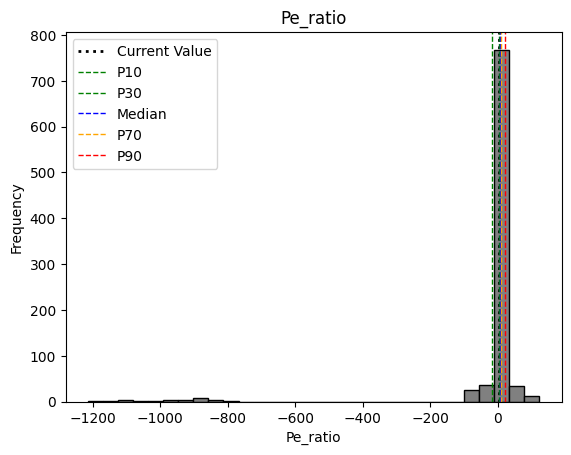

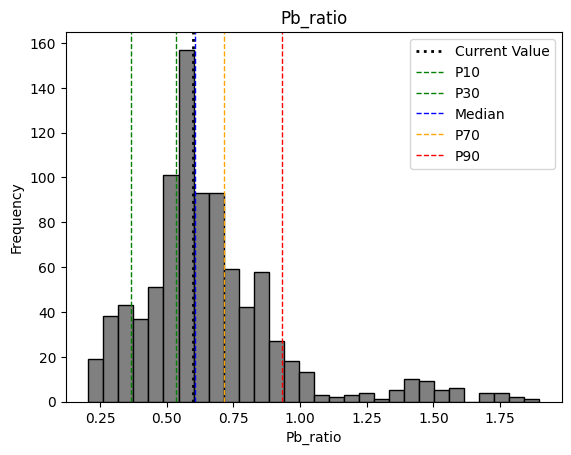

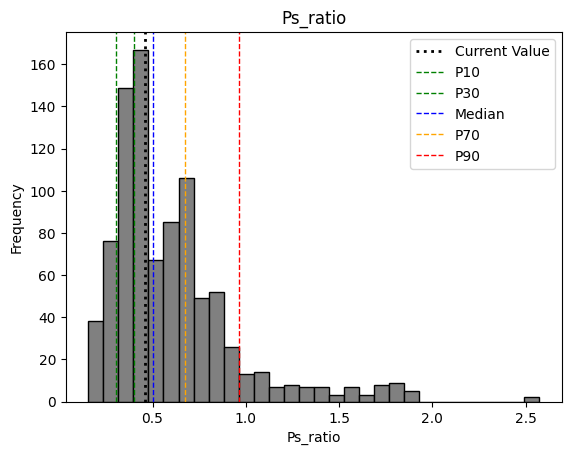

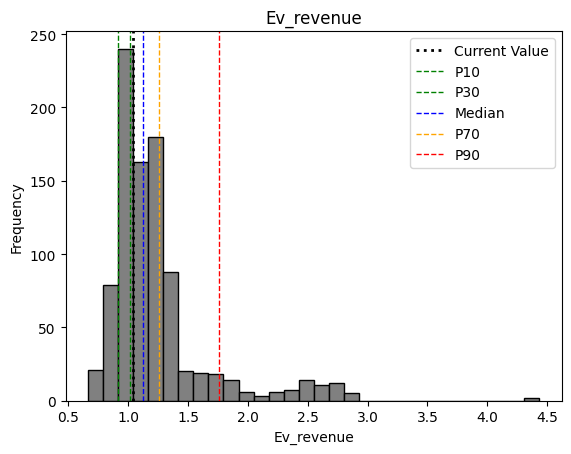

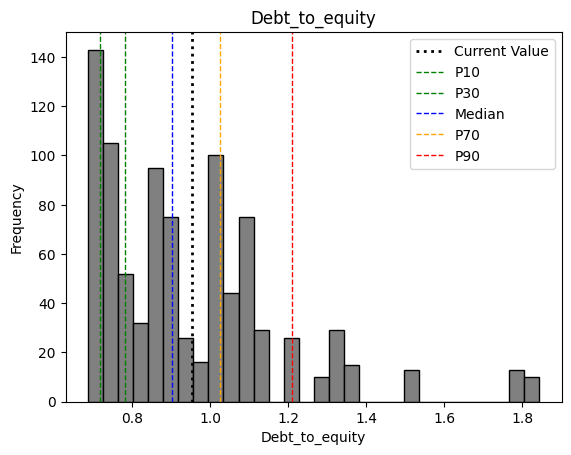

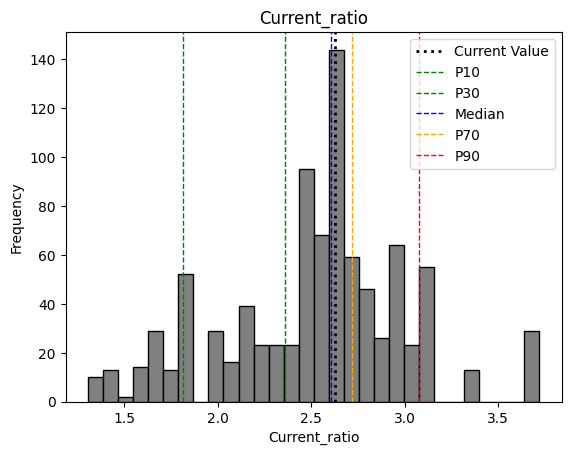

In [18]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [19]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.989459,0.171011,0.041135,-0.041859,-0.141891,-0.122882,0.277934
roe,0.989459,1.000000,0.172477,0.018235,-0.078122,-0.143001,-0.004579,0.213046
pe_ratio,0.171011,0.172477,1.000000,-0.100540,-0.134490,-0.108636,0.050154,0.077658
pb_ratio,0.041135,0.018235,-0.100540,1.000000,0.896065,0.700325,-0.120344,-0.168208
ps_ratio,-0.041859,-0.078122,-0.134490,0.896065,1.000000,0.888166,-0.182827,-0.198867
ev_revenue,-0.141891,-0.143001,-0.108636,0.700325,0.888166,1.000000,0.163139,-0.464065
debt_to_equity,-0.122882,-0.004579,0.050154,-0.120344,-0.182827,0.163139,1.000000,-0.607788
current_ratio,0.277934,0.213046,0.077658,-0.168208,-0.198867,-0.464065,-0.607788,1.000000


3 timestemos have been found!


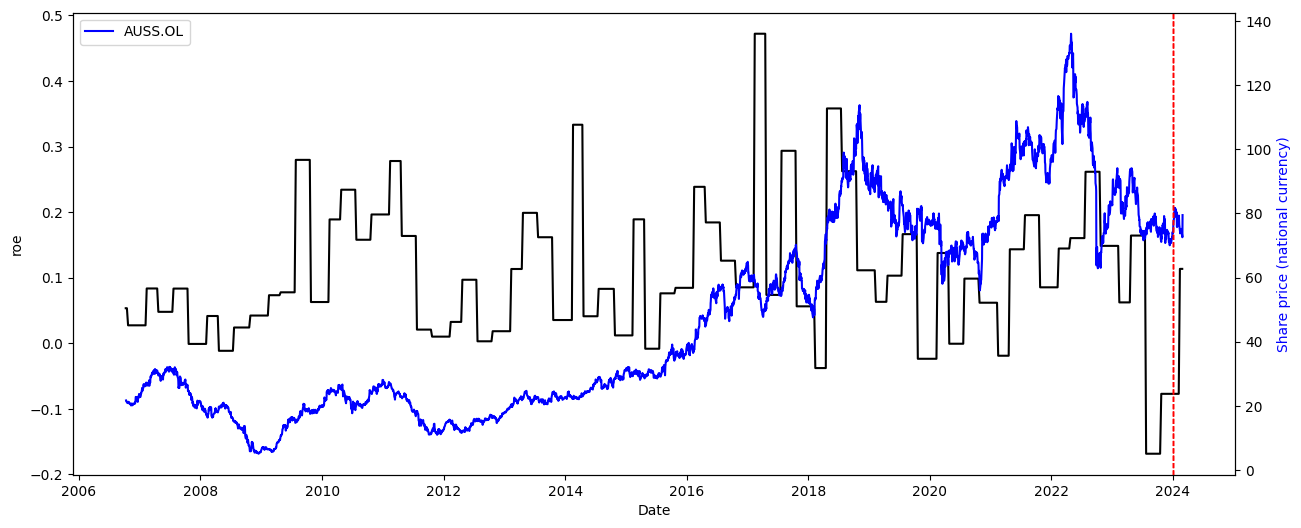

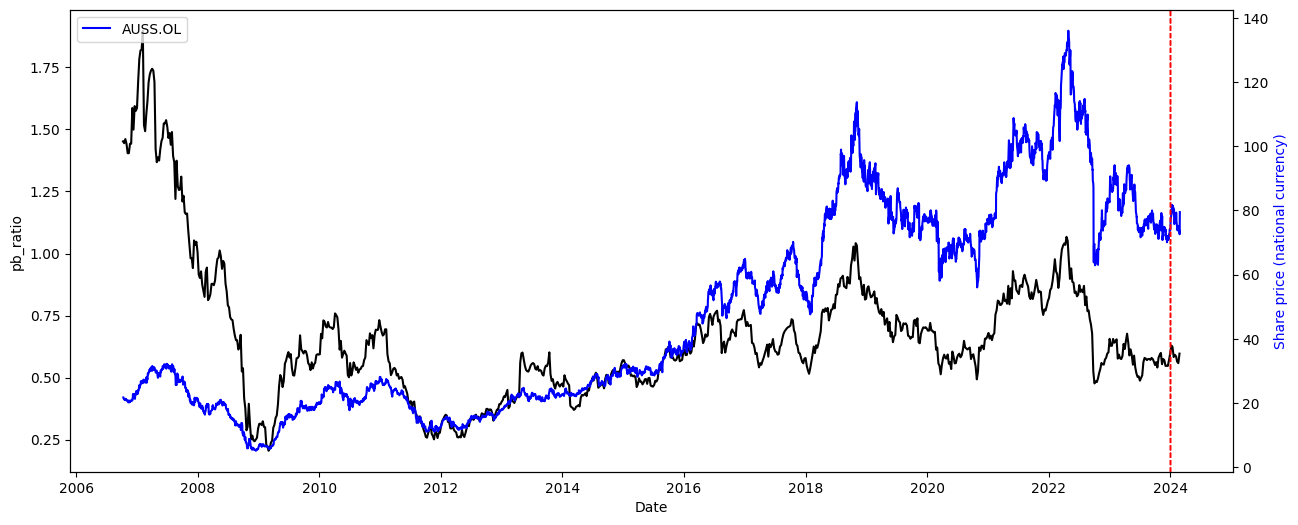

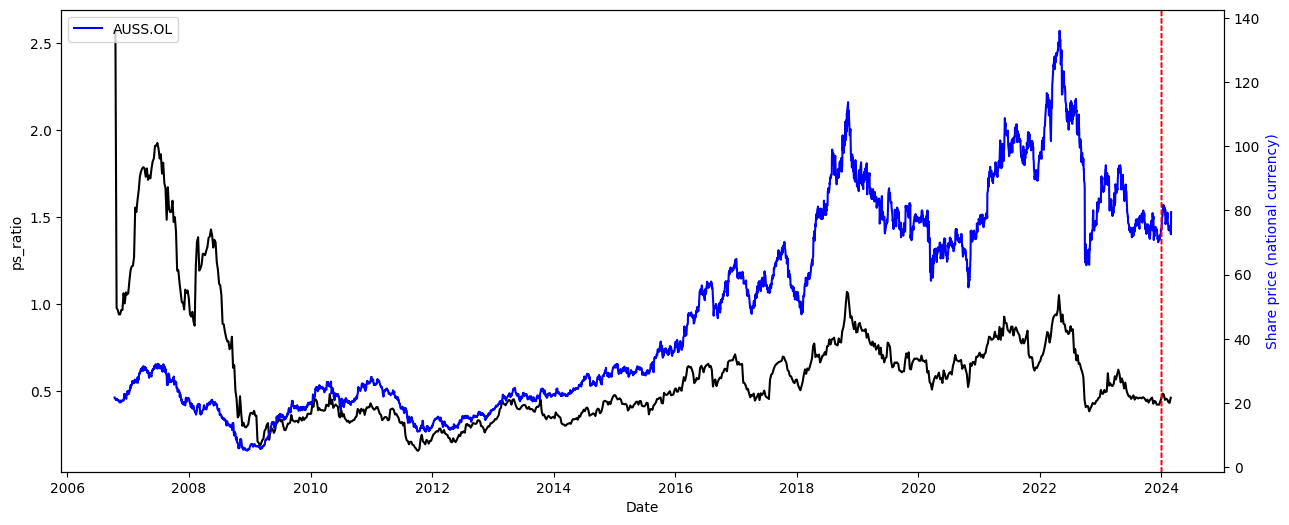

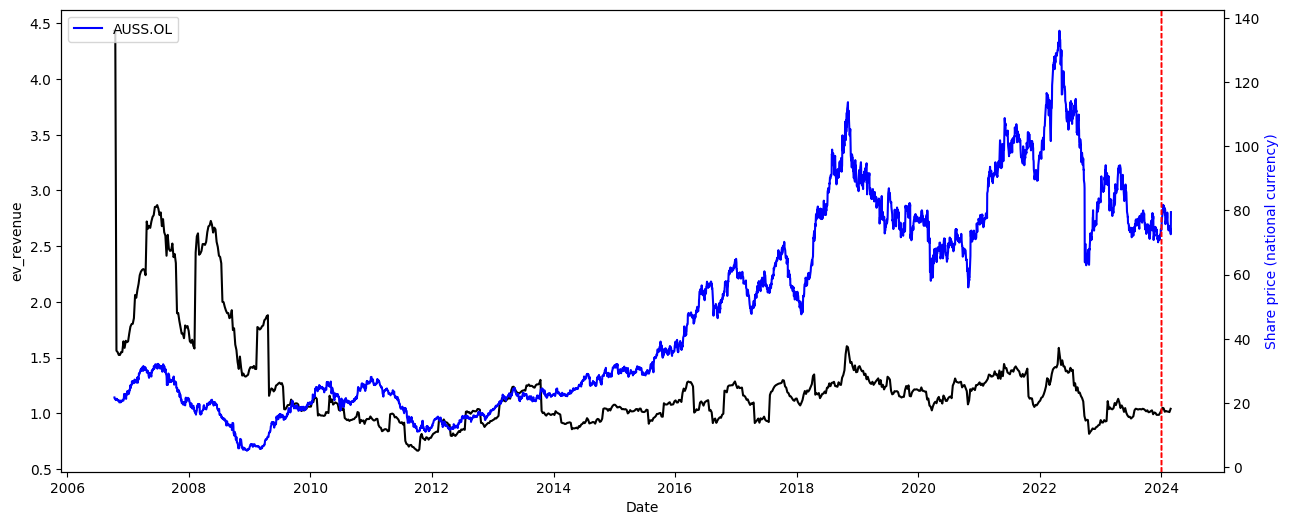

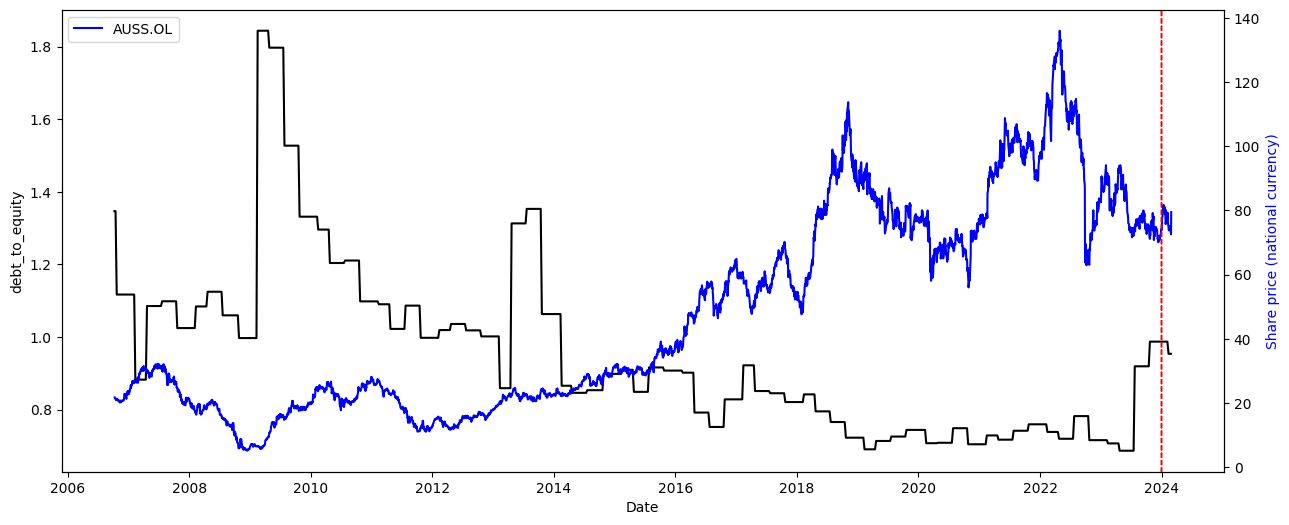

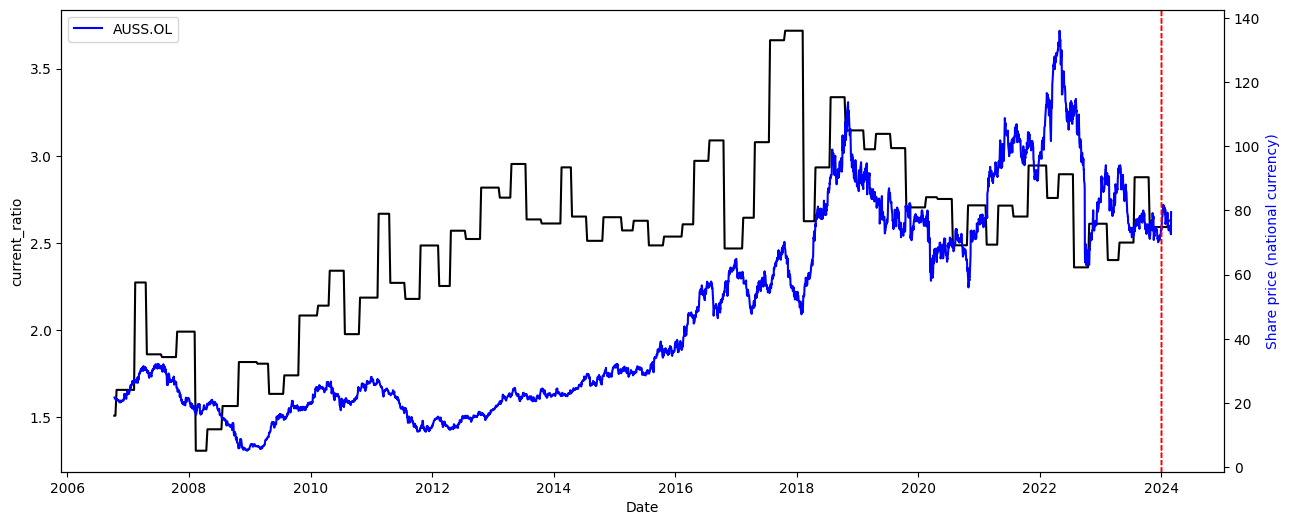

In [20]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2
    )